In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/wtbdata_245days.csv')
df

In [ ]:
df.head(60)

In [ ]:
df['Tmstamp'] = pd.to_datetime(df['Tmstamp'])
df

df['hour'] = df['Tmstamp'].dt.hour
df

In [ ]:
df.insert(0, 'hour',df['Tmstamp'].dt.hour)
df

In [ ]:
df.insert(1, 'minute',df['Tmstamp'].dt.minute)
df

In [ ]:
del df['Tmstamp']
del df['Day']
df

In [ ]:
#利用提取出来的分钟和小时来计算t_sin和t_cos
df.insert(3, 't_sin',np.sin((df['hour']*6+df['minute']/10)*2*np.pi/(24*6)))
df.insert(4, 't_cos',np.cos((df['hour']*6+df['minute']/10)*2*np.pi/(24*6)))
df

In [ ]:
#这一步处理填充空白值
df = df.fillna(axis=0, method='ffill')
df = df.fillna(axis=0,method='bfill')

In [ ]:
while df.isna().sum().sum()>0:
    df = df.fillna(axis=0, method='ffill')
    df = df.fillna(axis=0,method='bfill')

In [ ]:
df

In [ ]:
order = ['hour','minute','TurbID','t_sin','t_cos','Wdir','Ndir','Pab1','Pab2','Pab3','Wspd','Etmp','Itmp','Prtv','Patv']
df = df[order]

In [ ]:
df

In [ ]:
df.iloc[:,5:10] = df.iloc[:,5:10]/360
df

In [ ]:
dfv1 = df.values[:288+144,-1]

In [ ]:
from matplotlib import pyplot as plt
plt.figure(1)
fs = (10,4)
plt.figure(figsize=fs,dpi=120)
xs = np.arange(len(dfv1))
    
plt.title('Patv')
plt.xlabel('TMsteps')
plt.ylabel('MW')
#plt.plot(xs, eva_preds, '-.g', linewidth = 1.0, label = '24Hours_Predictions_AttentionBiGRU')
plt.plot(xs, dfv1, '-r', linewidth = 0.8, label = 'True_Price_Value')


plt.grid(linestyle='-.', linewidth = 1)
plt.legend()
#plt.savefig('Save_figure/forwardGRU_Atten.png', dpi=2600)
plt.show()
plt.show()

In [ ]:
#数据归一化处理
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
cols_data = df.columns[5:]   #选取来训练的所有数据列
df_data = df[cols_data]
df_data

In [ ]:
train_data = df_data[0:153*144]
train_data

In [ ]:
#scaler.fit(train_data.values)
data = scaler.fit_transform(df_data.values)
data

In [ ]:
data.shape

In [ ]:
data1 = np.hstack((df.values[:,3:5],data))
data1.shape

In [ ]:
data1

In [ ]:
len(data)

In [1]:
import paddle
import paddle.nn as nn

from paddle.io import Dataset
from paddle.static import InputSpec

import paddle.fluid as fluid

from paddle.fluid.dygraph import Linear
from paddle.fluid.dygraph import Layer, to_variable
import paddle.fluid.dygraph as dygraph
import gc
import numpy as np
import pandas as pd
import os
import argparse
import random

/Users/chenguibin/anaconda3/lib/python3.7/site-packages/socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable


In [2]:

class Scaler(object):
    """
    Desc: Normalization utilities
    """
    def __init__(self):
        self.mean = 0.
        self.std = 1.

    def fit(self, data):
        # type: (paddle.tensor) -> None
        """
        Desc:
            Fit the data
        Args:
            data:
        Returns:
            None
        """
        self.mean = np.mean(data)
        self.std = np.std(data)

    def transform(self, data):
        # type: (paddle.tensor) -> paddle.tensor
        """
        Desc:
            Transform the data
        Args:
            data:
        Returns:
            The transformed data
        """
        mean = paddle.to_tensor(self.mean).type_as(data).to(data.device) if paddle.is_tensor(data) else self.mean
        std = paddle.to_tensor(self.std).type_as(data).to(data.device) if paddle.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        # type: (paddle.tensor) -> paddle.tensor
        """
        Desc:
            Restore to the original data
        Args:
            data: the transformed data
        Returns:
            The original data
        """
        mean = paddle.to_tensor(self.mean) if paddle.is_tensor(data) else self.mean
        std = paddle.to_tensor(self.std) if paddle.is_tensor(data) else self.std
        return (data * std) + mean


In [3]:
from sklearn import preprocessing

class WindTurbineDataset(Dataset):
    """
    Desc: Data preprocessing,
          Here, e.g.    15 days for training,
                        3 days for validation,
                        and 6 days for testing
    """
    def __init__(self, data_path,
                 filename='my.csv',
                 flag='train',
                 size=None,
                 turbine_id=0,
                 task='MS',
                 target='Target',
                 scale=True,
                 start_col=3,       # the start column index of the data one aims to utilize
                 day_len=24 * 6,
                 train_days=15,     # 15 days
                 val_days=3,        # 3 days
                 test_days=6,       # 6 days
                 total_days=30      # 30 days
                 ):
        super().__init__()  #继承父类Dataset,且子类还会继续扩充时用super函数
        self.unit_size = day_len    #要预测的一整个序列长度
        if size is None:
            self.input_len = self.unit_size   #输入的序列长度
            self.output_len = self.unit_size    #要预测出来的序列长度
        else:
            self.input_len = size[0]
            self.output_len = size[1]
        # initialization
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]
        self.task = task
        self.target = target
        self.scale = scale
        self.start_col = start_col
        self.data_path = data_path
        self.filename = filename
        self.tid = turbine_id

        # If needed, we employ the predefined total_size (e.g. one month)
        self.total_size = self.unit_size * total_days   #计算总共有多少个每小时样本
        #
        self.train_size = train_days * self.unit_size   #预测的天数*要预测的一整个序列长度
        self.val_size = val_days * self.unit_size
        self.test_size = test_days * self.unit_size
        # self.test_size = self.total_size - train_size - val_size
        #
        # Or, if total_size is unavailable:
        # self.total_size = self.train_size + self.val_size + self.test_size
        self.__read_data__()

    def __read_data__(self):
        self.scaler = preprocessing.StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.data_path, self.filename))
        #在这里开始给原来的dataframe添加进去t_sin/cos
        df_raw['Tmstamp'] = pd.to_datetime(df_raw['Tmstamp'])
        df_raw.insert(0, 'hour',df_raw['Tmstamp'].dt.hour)
        df_raw.insert(1, 'minute',df_raw['Tmstamp'].dt.minute)
        del df_raw['Tmstamp']
        del df_raw['Day']
        df_raw.insert(3, 't_sin',np.sin((df_raw['hour']*6+df_raw['minute']/10)*2*np.pi/(24*6)))
        df_raw.insert(4, 't_cos',np.cos((df_raw['hour']*6+df_raw['minute']/10)*2*np.pi/(24*6)))
        #填充缺失值
        while df_raw.isna().sum().sum()>0:
            df_raw = df_raw.fillna(axis=0, method='ffill')
            df_raw = df_raw.fillna(axis=0,method='bfill')
            df_raw = df_raw.fillna(axis=0,method='bfill')
        #把角度调整到前面，后面是需要归一化处理的幅值变量，角度统一除以360转换为弧度制
        order = ['hour','minute','TurbID','t_sin','t_cos','Wdir','Ndir','Pab1','Pab2','Pab3','Wspd','Etmp','Itmp','Prtv','Patv']
        df_raw = df_raw[order]
        df_raw.iloc[:,5:10] = df_raw.iloc[:,5:10]/360  #所有角度转换成弧度制
        
        border1s = [self.tid * self.total_size,   #写成这样应该是默认全部风机的数据都堆叠在一起
                    self.tid * self.total_size + self.train_size - self.input_len,
                    self.tid * self.total_size + self.train_size + self.val_size - self.input_len
                    ]
        border2s = [self.tid * self.total_size + self.train_size,
                    self.tid * self.total_size + self.train_size + self.val_size,
                    self.tid * self.total_size + self.train_size + self.val_size + self.test_size
                    ]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        df_data = df_raw
        if self.task == 'M':
            cols_data = df_raw.columns[10:]   #角度之后的数据才做这种归一化处理
            df_data = df_raw[cols_data]
        elif self.task == 'MS':
            cols_data = df_raw.columns[10:]   #选取来训练的所有数据列
            df_data = df_raw[cols_data]
        elif self.task == 'S':
            df_data = df_raw[[self.tid, self.target]]

        # Turn off the SettingWithCopyWarning
        pd.set_option('mode.chained_assignment', None)

        df_data.replace(to_replace=np.nan, value=0, inplace=True)

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            #self.scaler.fit(train_data.values)  #这里的归一化其实是计算把所有feature一起计算了，我认为应该每个feature单独计算，使用sklearn的preprocessing可以实现
            data = self.scaler.fit_transform(df_data.values)  #把从Wspd开始的特征全体数据归一化
        else:
            data = df_data.values
        
        data = np.hstack((df_raw.values[:,3:10],data))
        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]  #注意到这里的data不包含TurbineID,
        self.raw_data = df_data[border1 + self.input_len:border2]  #这三个数据分别是干嘛的呢？

    def get_raw_data(self):
        return self.raw_data

    def __getitem__(self, index):    #在Dataloader中真正起作用的还是这个__getitem__函数，输入的index其实是一个长度为batch_size的随机下标，用来选择样本的
        #
        # Only for customized use.
        # When sliding window not used, e.g. prediction without overlapped input/output sequences
        if self.set_type >= 3:
            index = index * self.output_len
        #
        # Standard use goes here.
        # Sliding window with the size of input_len + output_len
        s_begin = index
        s_end = s_begin + self.input_len
        r_begin = s_end
        r_end = r_begin + self.output_len
        #seq_x = self.data_x[s_begin:s_end]   #这个是input的序列长度/序列中的每一行应该包含num_features列
        #seq_y = self.data_y[r_begin:r_end]  #这个是输出序列的长度
        seq_x = self.data_x[s_begin:s_end]   #这个是input的序列长度/序列中的每一行应该包含num_features列
        #seq_x2 = self.data_y[r_begin:r_end,:2] #这个是input的未来的特征/在风力发电预测这里没有未来特征，这里需要去除/有未来时刻t_sin特征
        seq_y = self.data_y[r_begin:r_end]  #这个是输出序列的长度
        #return [seq_x1,seq_x2], seq_y
        return seq_x, seq_y

    def __len__(self):
        # In our case, the sliding window is adopted, the number of samples is calculated as follows
        if self.set_type < 3:
            return len(self.data_x) - self.input_len - self.output_len + 1
        # Otherwise, if sliding window is not adopted
        return int((len(self.data_x) - self.input_len) / self.output_len)

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


In [4]:

def prep_env():
    # type: () -> dict
    """
    Desc:
        Prepare the experimental settings
    Returns:
        The initialized arguments
    """
    parser = argparse.ArgumentParser(description='Long Term Wind Power Forecasting')
    ###
    parser.add_argument('--data_path', type=str, default='./data/', help='Path to the data file')
    parser.add_argument('--filename', type=str, default='wtbdata_100days.csv',
                        help='Filename of the input data, change it if necessary')
    parser.add_argument('--task', type=str, default='MS', help='The type of forecasting task, '
                                                               'options:[M, S, MS]; '
                                                               'M: multivariate --> multivariate, '
                                                               'S: univariate --> univariate, '
                                                               'MS: multivariate --> univariate')
    parser.add_argument('--target', type=str, default='Patv', help='Target variable in S or MS task')
    parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='Location of model checkpoints')
    parser.add_argument('--input_len', type=int, default=72, help='Length of the input sequence')
    parser.add_argument('--output_len', type=int, default=288, help='The length of predicted sequence')
    parser.add_argument('--start_col', type=int, default=2, help='Index of the start column of the meaningful variables')
    parser.add_argument('--in_var', type=int, default=12, help='Number of the input variables')
    parser.add_argument('--out_var', type=int, default=1, help='Number of the output variables')
    parser.add_argument('--teacher_ratio', type=float, default=0.3, help='Number of the teacher ratio')
    
    parser.add_argument('--day_len', type=int, default=144, help='Number of observations in one day')
    parser.add_argument('--train_size', type=int, default=80, help='Number of days for training')
    parser.add_argument('--val_size', type=int, default=10, help='Number of days for validation')
    parser.add_argument('--test_size', type=int, default=10, help='Number of days for testing')
    parser.add_argument('--total_size', type=int, default=14, help='Number of days for the whole dataset')
    parser.add_argument('--lstm_layer', type=int, default=2, help='Number of LSTM layers')
    parser.add_argument('--dropout', type=float, default=0.1, help='Dropout')
    parser.add_argument('--num_workers', type=int, default=5, help='#workers for data loader')
    parser.add_argument('--train_epochs', type=int, default=15, help='Train epochs')
    parser.add_argument('--batch_size', type=int, default=32, help='Batch size for the input training data')
    parser.add_argument('--patience', type=int, default=20, help='Early stopping patience')
    parser.add_argument('--lr', type=float, default=1e-4, help='Optimizer learning rate')
    parser.add_argument('--lr_adjust', type=str, default='type2', help='Adjust learning rate')
    parser.add_argument('--use_gpu', type=bool, default=True, help='Whether or not use GPU')
    parser.add_argument('--gpu', type=int, default=0, help='GPU ID')
    # parser.add_argument('--use_multi_gpu', action='store_true', default=False, help='Use multiple gpus or not')
    parser.add_argument('--capacity', type=int, default=1, help="The capacity of a wind farm, "
                                                                  "i.e. the number of wind turbines in a wind farm")
    parser.add_argument('--turbine_id', type=int, default=0, help='Turbine ID')
    parser.add_argument('--pred_file', type=str, default='./predict.py',
                        help='The path to the script for making predictions')
    parser.add_argument('--stride', type=int, default=134, help='The stride that a window adopts to roll the test set')
    parser.add_argument('--is_debug', type=bool, default=False, help='True or False')
    #args = parser.parse_args()
    args = parser.parse_args(args=[])
    settings = {
        "data_path": args.data_path,
        "filename": args.filename,
        "task": args.task,
        "target": args.target,
        "checkpoints": args.checkpoints,
        "input_len": args.input_len,
        "output_len": args.output_len,
        "start_col": args.start_col,
        "in_var": args.in_var,
        "out_var": args.out_var,
        "teacher_ratio":args.teacher_ratio,
        "day_len": args.day_len,
        "train_size": args.train_size,
        "val_size": args.val_size,
        "test_size": args.test_size,
        "total_size": args.total_size,
        "lstm_layer": args.lstm_layer,
        "dropout": args.dropout,
        "num_workers": args.num_workers,
        "train_epochs": args.train_epochs,
        "batch_size": args.batch_size,
        "patience": args.patience,
        "lr": args.lr,
        "lr_adjust": args.lr_adjust,
        "capacity": args.capacity,
        "turbine_id": args.turbine_id,
        "pred_file": args.pred_file,
        "stride": args.stride,
        "is_debug": args.is_debug
    }
    ###
    # Prepare the GPUs
    if paddle.device.is_compiled_with_cuda():
        args.use_gpu = True
        paddle.device.set_device('gpu:{}'.format(args.gpu))
    else:
        args.use_gpu = False
        paddle.device.set_device('cpu')

    # if args.use_gpu and args.use_multi_gpu:
    #     args.devices = args.devices.replace(' ', '')
    #     device_ids = args.devices.split(',')
    #     args.device_ids = [int(id_) for id_ in device_ids]
    #     args.gpu = args.device_ids[0]
    #     settings.update(
    #         {
    #             "use_gpu": args.use_gpu,
    #             "devices": args.devices,
    #             "device_ids": args.device_ids,
    #             "gpu": args.gpu,
    #             "use_multi_gpu": args.use_multi_gpu
    #          }
    #     )
    # else:
    #     settings.update(
    #         {
    #             "use_gpu": args.use_gpu,
    #             "gpu": args.gpu,
    #             "use_multi_gpu": args.use_multi_gpu
    #          }
    #     )
    print("Experimental settings are: \n{}".format(str(settings)))
    return settings


In [5]:
settings = prep_env()

Experimental settings are: 
{'data_path': './data/', 'filename': 'wtbdata_100days.csv', 'task': 'MS', 'target': 'Patv', 'checkpoints': './checkpoints/', 'input_len': 72, 'output_len': 288, 'start_col': 2, 'in_var': 12, 'out_var': 1, 'teacher_ratio': 0.3, 'day_len': 144, 'train_size': 80, 'val_size': 10, 'test_size': 10, 'total_size': 14, 'lstm_layer': 2, 'dropout': 0.1, 'num_workers': 5, 'train_epochs': 15, 'batch_size': 32, 'patience': 20, 'lr': 0.0001, 'lr_adjust': 'type2', 'capacity': 1, 'turbine_id': 0, 'pred_file': './predict.py', 'stride': 134, 'is_debug': False}


In [6]:
from typing import Callable
import time
import numpy as np
import paddle
import paddle.nn as nn
import random
from paddle.io import DataLoader
#from model import BaselineGruModel
from Attention_GRU import Atten_En_Decoder
from Encoder_decoder_GRU import FeatureGruModel,BaselineGruModel,En_Decoder_GRU

def adjust_learning_rate(optimizer, epoch, args):
    # type: (paddle.optimizer.Adam, int, dict) -> None
    """
    Desc:
        Adjust learning rate
    Args:
        optimizer:
        epoch:
        args:
    Returns:
        None
    """
    # lr = args.lr * (0.2 ** (epoch // 2))
    lr_adjust = {}
    if args["lr_adjust"] == 'type1':
        # learning_rate = 0.5^{epoch-1}
        lr_adjust = {epoch: args["lr"] * (0.50 ** (epoch - 1))}
    elif args["lr_adjust"] == 'type2':
        lr_adjust = {
            2: 5e-5, 10: 1e-5, 16: 5e-6
        }
    if epoch in lr_adjust:
        lr = lr_adjust[epoch]
        optimizer.set_lr(lr)


In [7]:

class Experiment(object):
    """
    Desc:
        The experiment to train, validate and test a model
    """
    def __init__(self, args):
        # type: (dict) -> None
        """
        Desc:
            __init__
        Args:
            args: the arguments to initialize the experimental environment
        """
        self.model = BaselineGruModel(args)
        self.args = args

    def get_model(self):
        # type: () -> BaselineGruModel
        """
        Desc:
            the model
        Returns:
            An instance of the model
        """
        return self.model

    def get_args(self):
        # type: () -> dict
        """
        Desc:
            Get the arguments
        Returns:
            A dict
        """
        return self.args

    def get_data(self, flag):
        # type: (str) -> (WindTurbineDataset, DataLoader)
        """
        Desc:
            get_data
        Args:
            flag: train or test
        Returns:
            A dataset and a dataloader
        """
        if flag == 'test':
            shuffle_flag = False
            drop_last = True
        else:
            shuffle_flag = True
            drop_last = True
        data_set = WindTurbineDataset(
            data_path=self.args["data_path"],
            filename=self.args["filename"],
            flag=flag,
            size=[self.args["input_len"], self.args["output_len"]],
            task=self.args["task"],
            target=self.args["target"],
            start_col=self.args["start_col"],
            turbine_id=self.args["turbine_id"],
            day_len=self.args["day_len"],
            train_days=self.args["train_size"],
            val_days=self.args["val_size"],
            test_days=self.args["test_size"],
            total_days=self.args["total_size"]
        )
        data_loader = DataLoader(
            data_set,
            batch_size=self.args["batch_size"],
            shuffle=shuffle_flag,
            num_workers=self.args["num_workers"],
            drop_last=drop_last
        )
        return data_set, data_loader

    def get_optimizer(self):
        # type: () -> paddle.optimizer.Adam
        """
        Desc:
            Get the optimizer
        Returns:
            An optimizer
        """
        clip = paddle.nn.ClipGradByNorm(clip_norm=50.0)
        model_optim = paddle.optimizer.Adam(parameters=self.model.parameters(),
                                            learning_rate=self.args["lr"],
                                            grad_clip=clip)
        return model_optim

    @staticmethod
    def get_criterion():
        # type: () -> nn.MSELoss
        """
        Desc:
            Use the mse loss as the criterion
        Returns:
            MSE loss
        """
        criterion = nn.MSELoss(reduction='mean')  #最后返回所有样本计算出来的均值
        return criterion

    def process_one_batch(self, batch_x, batch_y):
        # type: (list[paddle.tensor], paddle.tensor) -> (paddle.tensor, paddle.tensor)
        """
        Desc:
            Process a batch
        Args:
            batch_x:
            batch_y:
        Returns:
            prediction and ground truth
        """
        batch_x = batch_x.astype('float32')
        #batch_x2 = batch_x[1].astype('float32')
        batch_y = batch_y.astype('float32')
        # If the task is the multivariate-to-univariate forecasting task,
        # the last column is the target variable to be predicted
        f_dim = -1 if self.args["task"] == 'MS' else 0
        batch_y = batch_y[:, -self.args["output_len"]:, f_dim:].astype('float32')
        
        #sample, att_list = self.model(batch_x1,batch_x2,batch_y)
        sample = self.model(batch_x)

        sample = sample[..., -args['output_len']:, f_dim:].astype('float32')
        return sample, batch_y




In [8]:

fix_seed = 3407
random.seed(fix_seed)
paddle.seed(fix_seed)
np.random.seed(fix_seed)


def traverse_wind_farm(method, params, model_path, flag='train'):
    # type: (Callable, dict, str, str) -> list
    """
    Desc:
        Traverse the turbines in a wind farm on by one
    Args:
        method: the method for training or testing on the records of one turbine
        params: the arguments initialized
        model_path: the folder name of the model
        flag: 'train' or 'test'
    Returns:
        Predictions (for test) or None
    """
    responses = []
    start_time = time.time()
    for i in range(params["capacity"]):
        params["turbine_id"] = i
        exp = Experiment(params)
        if 'train' == flag:
            print('>>>>>>> Training Turbine {:3d} >>>>>>>>>>>>>>>>>>>>>>>>>>\n'.format(i))
            method(exp, model_path, is_debug=params["is_debug"])
        elif 'test' == flag:
            print('>>>>>>> Forecasting Turbine {:3d} >>>>>>>>>>>>>>>>>>>>>>>>>>\n'.format(i))
            res = method(exp, model_path)
            responses.append(res)
        else:
            pass
        paddle.device.cuda.empty_cache()
        if params["is_debug"]:
            end_time = time.time()
            print("Elapsed time for {} turbine {} is {} secs".format("training" if "train" == flag else "predicting", i,
                                                                     end_time - start_time))
            start_time = end_time
    if 'test' == flag:
        return responses


In [9]:
experiment = Experiment(settings)
args = experiment.get_args()
model = experiment.get_model()
train_data,tran_loader= experiment.get_data(flag='train')

/Users/chenguibin/anaconda3/lib/python3.7/site-packages/paddle/fluid/reader.py:356: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  "DataLoader with multi-process mode is not supported on MacOs and Windows currently." \


In [10]:

class EarlyStopping(object):
    """
    Desc:
        EarlyStopping
    """
    def __init__(self, patience=20, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.best_model = False

    def save_checkpoint(self, val_loss, model, path, tid):
        # type: (nn.MSELoss, BaselineGruModel, str, int) -> None
        """
        Desc:
            Save current checkpoint
        Args:
            val_loss: the validation loss
            model: the model
            path: the path to be saved
            tid: turbine ID
        Returns:
            None
        """
        self.best_model = True
        self.val_loss_min = val_loss
        paddle.save(model.state_dict(), path + '/' + 'model_ED' + 'turbine{}'.format(str(tid)))  #这里是针对每一个turbine id训练一个模型吗？

    def __call__(self, val_loss, model, path, tid):
        # type: (nn.MSELoss, BaselineGruModel, str, int) -> None
        """
        Desc:
            __call__
        Args:
            val_loss: the validation loss
            model: the model
            path: the path to be saved
            tid: turbine ID
        Returns:
            None
        """
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path, tid)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.best_model = False
            self.save_checkpoint(val_loss, model, path, tid)
            #if self.counter >= self.patience:
                #self.early_stop = True
        else:
            self.best_score = score
            self.update_hidden = True
            self.save_checkpoint(val_loss, model, path, tid)
            self.counter = 0


In [11]:

def val(experiment, data_loader, criterion):
    # type: (Experiment, DataLoader, Callable) -> np.array
    """
    Desc:
        Validation function
    Args:
        experiment:
        data_loader:
        criterion:
    Returns:
        The validation loss
    """
    validation_loss = []
    for i, (batch_x, batch_y) in enumerate(data_loader):
        sample, true = experiment.process_one_batch(batch_x, batch_y)
        loss = criterion(sample, true)
        validation_loss.append(loss.item())
    validation_loss = np.average(validation_loss)
    return validation_loss



In [12]:

fix_seed = 3407
random.seed(fix_seed)
paddle.seed(fix_seed)
np.random.seed(fix_seed)


def traverse_wind_farm(method, params, model_path, flag='train'):
    # type: (Callable, dict, str, str) -> list
    """
    Desc:
        Traverse the turbines in a wind farm on by one
    Args:
        method: the method for training or testing on the records of one turbine
        params: the arguments initialized
        model_path: the folder name of the model
        flag: 'train' or 'test'
    Returns:
        Predictions (for test) or None
    """
    responses = []
    start_time = time.time()
    for i in range(params["capacity"]):
        params["turbine_id"] = i
        exp = Experiment(params)
        if 'train' == flag:
            print('>>>>>>> Training Turbine {:3d} >>>>>>>>>>>>>>>>>>>>>>>>>>\n'.format(i))
            method(exp, model_path, is_debug=params["is_debug"])
        elif 'test' == flag:
            print('>>>>>>> Forecasting Turbine {:3d} >>>>>>>>>>>>>>>>>>>>>>>>>>\n'.format(i))
            res = method(exp, model_path)
            responses.append(res)
        else:
            pass
        paddle.device.cuda.empty_cache()
        if params["is_debug"]:
            end_time = time.time()
            print("Elapsed time for {} turbine {} is {} secs".format("training" if "train" == flag else "predicting", i,
                                                                     end_time - start_time))
            start_time = end_time
    if 'test' == flag:
        return responses


In [13]:

def train_and_val(experiment, model_folder, is_debug=False):
    # type: (Experiment, str, bool) -> None
    """
    Desc:
        Training and validation
    Args:
        experiment:
        model_folder: folder name of the model
        is_debug:
    Returns:
        None
    """
    args = experiment.get_args()
    model = experiment.get_model()
    train_data, train_loader = experiment.get_data(flag='train')
    val_data, val_loader = experiment.get_data(flag='val')

    path_to_model = os.path.join(args["checkpoints"], model_folder)
    if not os.path.exists(path_to_model):
        os.makedirs(path_to_model)

    time_now = time.time()
    early_stopping = EarlyStopping(patience=args["patience"], verbose=True)
    model_optim = experiment.get_optimizer()
    criterion = Experiment.get_criterion()

    epoch_start_time = time.time()
    for epoch in range(args["train_epochs"]):
        iter_count = 0
        train_loss = []
        model.train()
        for i, (batch_x, batch_y) in enumerate(train_loader):
            iter_count += 1
            sample, truth = experiment.process_one_batch(batch_x, batch_y)
            
            loss = criterion(sample, truth)
            train_loss.append(loss.item())
            loss.backward()
            model_optim.minimize(loss)
            model_optim.step()
        val_loss = val(experiment, val_loader, criterion)
        print('Epoch: {}, Train loss average'.format(epoch), np.mean(np.array(train_loss)))

        if is_debug:
            train_loss = np.average(train_loss)
            epoch_end_time = time.time()
            print("Epoch: {}, \nTrain Loss: {}, \nValidation Loss: {}".format(epoch, train_loss, val_loss))
            print("Elapsed time for epoch-{}: {}".format(epoch, epoch_end_time - epoch_start_time))
            epoch_start_time = epoch_end_time

        # Early Stopping if needed
        early_stopping(val_loss, model, path_to_model, args["turbine_id"])
        if early_stopping.early_stop:
            print("Early stopped! ")
            break
        adjust_learning_rate(model_optim, epoch + 1, args)


In [14]:

if __name__ == "__main__":
    settings = prep_env()
    #
    # Set up the initial environment
    # Current settings for the model
    cur_setup = '{}_t{}_i{}_o{}_ls{}_train{}_val{}_base'.format(
        settings["filename"], settings["task"], settings["input_len"], settings["output_len"], settings["lstm_layer"],
        settings["train_size"], settings["val_size"]  #计划对每个tid保存一个模型，明天在这里加上id
    )
    traverse_wind_farm(train_and_val, settings, cur_setup)


Experimental settings are: 
{'data_path': './data/', 'filename': 'wtbdata_100days.csv', 'task': 'MS', 'target': 'Patv', 'checkpoints': './checkpoints/', 'input_len': 72, 'output_len': 288, 'start_col': 2, 'in_var': 12, 'out_var': 1, 'teacher_ratio': 0.3, 'day_len': 144, 'train_size': 80, 'val_size': 10, 'test_size': 10, 'total_size': 14, 'lstm_layer': 2, 'dropout': 0.1, 'num_workers': 5, 'train_epochs': 15, 'batch_size': 32, 'patience': 20, 'lr': 0.0001, 'lr_adjust': 'type2', 'capacity': 1, 'turbine_id': 0, 'pred_file': './predict.py', 'stride': 134, 'is_debug': False}
>>>>>>> Training Turbine   0 >>>>>>>>>>>>>>>>>>>>>>>>>>



KeyboardInterrupt: 

In [ ]:
args["output_len"]

In [ ]:
test_data, test_loader = experiment.get_data(flag='test')

In [ ]:
cur_setup = '{}_t{}_i{}_o{}_ls{}_train{}_val{}_base'.format(
        settings["filename"], settings["task"], settings["input_len"], settings["output_len"], settings["lstm_layer"],
        settings["train_size"], settings["val_size"]
    )
model_folder = cur_setup

In [ ]:
model_folder

In [ ]:
checkpoints/wtbdata_100days.csv_tMS_i72_o288_ls2_train80_val10

In [15]:
model_folder ='wtbdata_100days.csv_tMS_i72_o288_ls2_train80_val10_epoch20'

In [16]:
test_data, test_loader = experiment.get_data(flag='test')
predictions = []
true_lst = []
fix_seed = 3407
random.seed(fix_seed)
paddle.seed(fix_seed)
np.random.seed(fix_seed)


for i in range(8):
    single_seqx, single_seqy = test_data.__getitem__(i*args["input_len"])
    #print(single_seqy.shape)
    single_seqx1 = single_seqx.astype('float32')
    #single_seqx2 = single_seqx[1].astype('float32')
    single_seqy = single_seqy.astype('float32')
    f_dim = -1 if args["task"] == 'MS' else 0
    
    single_seqy = single_seqy[-args["output_len"]:, f_dim:].astype('float32')
    #print('single_seqy shape:', single_seqy.shape)
    enc_x1 = paddle.to_tensor(single_seqx1).unsqueeze(0)
    #enc_x2 = paddle.to_tensor(single_seqx2).unsqueeze(0)
    enc_y = paddle.to_tensor(single_seqy).unsqueeze(0)
    #print(enc_x.shape)
    model = experiment.get_model()
    
    path_to_model = os.path.join(args["checkpoints"], model_folder, 'model_EDturbine{}'.format(0))
    model.set_state_dict(paddle.load(path_to_model))

    single_pred = experiment.model(enc_x1)
    predictions.append(np.array(single_pred))
    single_seqy = single_seqy.reshape(-1,single_seqy.shape[0],single_seqy.shape[1])
    print(single_seqy.shape)
    true_lst.append(np.array(single_seqy))

(1, 288, 1)
(1, 288, 1)
(1, 288, 1)
(1, 288, 1)
(1, 288, 1)
(1, 288, 1)
(1, 288, 1)
(1, 288, 1)


/Users/chenguibin/anaconda3/lib/python3.7/site-packages/paddle/fluid/reader.py:356: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  "DataLoader with multi-process mode is not supported on MacOs and Windows currently." \


In [17]:
len(true_lst)

8

In [18]:
true_lst[0].shape

(1, 288, 1)

In [19]:
true_lst = np.array(true_lst).reshape(8,288,1)
true_lst

array([[[-0.7708391 ],
        [-0.7708391 ],
        [-0.7708391 ],
        ...,
        [-0.7708391 ],
        [-0.7708391 ],
        [-0.7708391 ]],

       [[-0.7708391 ],
        [-0.7708391 ],
        [-0.7708391 ],
        ...,
        [-0.7708391 ],
        [-0.7708391 ],
        [-0.7708391 ]],

       [[ 1.4066826 ],
        [ 1.3353915 ],
        [ 2.7820103 ],
        ...,
        [-0.7708391 ],
        [-0.7708391 ],
        [-0.7708391 ]],

       ...,

       [[-0.7708391 ],
        [-0.7708391 ],
        [-0.7708391 ],
        ...,
        [-0.6581469 ],
        [-0.5733376 ],
        [-0.47276112]],

       [[-0.7708391 ],
        [-0.7708391 ],
        [-0.7708391 ],
        ...,
        [-0.7708391 ],
        [-0.7708391 ],
        [-0.7708391 ]],

       [[-0.7708391 ],
        [-0.7708391 ],
        [-0.7708391 ],
        ...,
        [-0.7708391 ],
        [-0.7708391 ],
        [-0.7708391 ]]], dtype=float32)

In [20]:
predictions

[array([[[-2.70132363e-01],
         [-8.45375001e-01],
         [-6.24191940e-01],
         [-5.17013431e-01],
         [-7.37157524e-01],
         [-6.14415467e-01],
         [-5.91673553e-01],
         [-3.81902337e-01],
         [-4.17244375e-01],
         [-6.77710474e-01],
         [-2.00411975e-01],
         [-4.14653301e-01],
         [-3.26885104e-01],
         [-4.32095706e-01],
         [-3.65869224e-01],
         [-1.02060854e-01],
         [-3.65789473e-01],
         [-2.74435163e-01],
         [-2.67467201e-01],
         [-3.68418753e-01],
         [-2.94775784e-01],
         [-1.81879103e-01],
         [-7.66707659e-02],
         [-2.19851911e-01],
         [-3.12871099e-01],
         [-2.76844084e-01],
         [-2.16783524e-01],
         [-2.20211208e-01],
         [-8.94429386e-02],
         [-1.99982762e-01],
         [-5.33535779e-02],
         [-2.16794789e-01],
         [-2.13588119e-01],
         [-1.83794200e-01],
         [-1.51845872e-01],
         [ 4.8916608

In [21]:
len(predictions)

8

In [22]:
predictions[0].shape

(1, 288, 1)

In [23]:
predictions = np.array(predictions)
#predictions

In [24]:
predictions.shape

(8, 1, 288, 1)

In [25]:
predictions = predictions.reshape(-1, predictions.shape[-2], predictions.shape[-1])
predictions.shape

(8, 288, 1)

In [26]:
all_pre = np.repeat(predictions,5,axis=-1)
all_pre.shape

(8, 288, 5)

In [27]:
predictions = test_data.inverse_transform(all_pre)
predictions.shape

(8, 288, 5)

In [28]:
predictions = predictions[:,:,-1]

In [29]:
len(predictions)

8

In [30]:
preds = []
for l in predictions:
    preds.append(l.squeeze())
#preds

In [31]:
len(preds)

8

In [32]:
pp = []
for k in preds:
    pp.append(np.array(k.squeeze()))
#pp

In [33]:
len(pp)

8

In [34]:
ppp = []
for w in range(len(pp)):
    for j in range(len(pp[w])):
        ppp.append(pp[w][j])
#ppp

In [35]:
true_lst.shape

(8, 288, 1)

In [36]:
true_lst = true_lst.reshape(-1, true_lst.shape[-2], true_lst.shape[-1])
true_lst.shape

(8, 288, 1)

In [37]:
all_tr = np.repeat(true_lst,5,axis=-1)
all_tr.shape

(8, 288, 5)

In [38]:
true_lst = test_data.inverse_transform(all_tr)
true_lst.shape

(8, 288, 5)

In [39]:
true_lst = true_lst[:,:,-1]

In [40]:
trs = []
for l in true_lst:
    trs.append(l.squeeze())
#trs

In [41]:
tt = []
for k in trs:
    tt.append(np.array(k.squeeze()))
#tt

In [42]:
ttt = []
for w in range(len(tt)):
    for j in range(len(tt[w])):
        ttt.append(tt[w][j])
#ttt

true_list = []
for i in range(len(true_lst)):
    for k in range(true_lst[i].shape[0]):
        true_list.append(true_lst[i][k,-1])
true_list

In [43]:
eva_preds = np.array(ppp)
ground_tr = np.array(ttt)

In [44]:
eva_preds.shape

(2304,)

In [45]:
ground_tr.shape

(2304,)

In [46]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

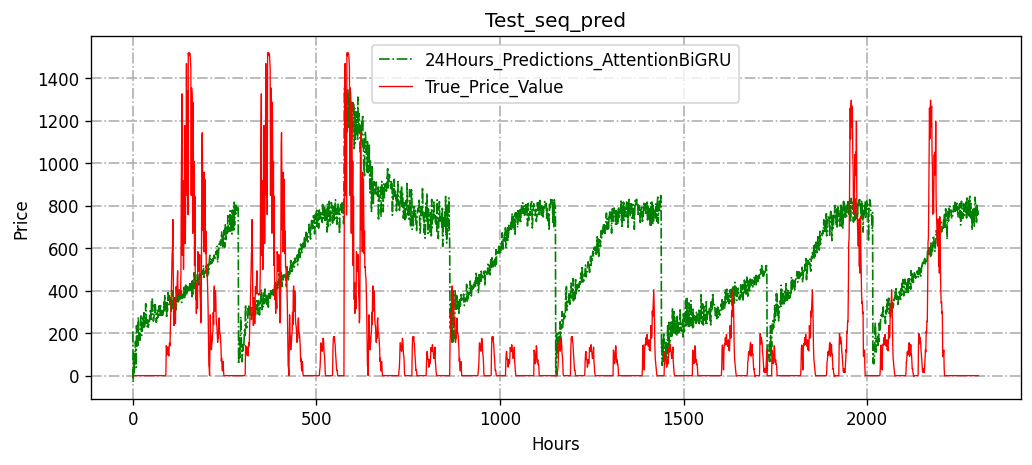

In [47]:
plt.figure(1)
fs = (10,4)
plt.figure(figsize=fs,dpi=120)
xs = np.arange(len(ground_tr))
#xs = np.arange(288*2)
    
plt.title('Test_seq_pred')
plt.xlabel('Hours')
plt.ylabel('Price')
plt.plot(xs, eva_preds, '-.g', linewidth = 1.0, label = '24Hours_Predictions_AttentionBiGRU')
plt.plot(xs, ground_tr, '-r', linewidth = 0.8, label = 'True_Price_Value')


plt.grid(linestyle='-.', linewidth = 1)
plt.legend()
#plt.savefig('model_folder.png', dpi=800)
plt.show()

In [ ]:
#model check
seqx,seqy = train_data.__getitem__(1)
seqx.shape

In [ ]:
seqx = seqx.reshape(1,144,12)
seqx

In [ ]:
x_enc = paddle.to_tensor(seqx)
type(seqx)

In [ ]:
import random
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

from paddle.io import Dataset
from paddle.static import InputSpec

import paddle.fluid as fluid

from paddle.fluid.dygraph import Linear
from paddle.fluid.dygraph import Layer, to_variable
import paddle.fluid.dygraph as dygraph
import gc
import numpy as np
output_len = 288
hidC = 12
hidR = 48
out = 1
dropout = nn.Dropout('0.1')
lstm = nn.GRU(input_size=hidC, hidden_size=hidR, num_layers=2,
                           time_major=True)   #time major为True时，输入lstm的形式就是seq,batch,dims
projection = nn.Linear(hidR, out)

In [ ]:
x1 = paddle.concat([
                                            x_enc[:,:,:2],   #t_sin,t_cos
                                            x_enc[:,:,7] * paddle.sin(np.pi * 2 *x_enc[:,:,2]), #风速*风向
                                            x_enc[:,:,7] * paddle.cos(np.pi * 2 *x_enc[:,:,2]), 
                                            paddle.sin(np.pi * 2 *x_enc[:,:,3]),
                                            paddle.cos(np.pi * 2 *x_enc[:,:,3]),  #Ndir
                                            paddle.sin(np.pi * 2 *x_enc[:,:,4]),
                                            paddle.cos(np.pi * 2 *x_enc[:,:,4]),   #Pb1
                                            paddle.sin(np.pi * 2 *x_enc[:,:,5]),
                                            paddle.cos(np.pi * 2 *x_enc[:,:,5]),    #Pb2
                                            paddle.sin(np.pi * 2 *x_enc[:,:,6]),
                                            paddle.cos(np.pi * 2 *x_enc[:,:,6]),   #Pb3
                                            x_enc[:,:,8:],   #共4项:温度、有功无功
                                        ], axis=-1)     # 2+10+4 = 16

In [ ]:
x1.shape

In [ ]:
s = x_enc[:,:,7] * paddle.sin(np.pi * 2 *x_enc[:,:,2])
s.shape

In [ ]:
input1 = paddle.zeros(shape=[1,144,12],dtype='float32')
d = input1[:,:,3:4] * paddle.sin(np.pi * 2 *input1[:,:,4:5])

In [ ]:
d.shape